## Is it a bird?

In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
    print('Connected to the internet')
except socket.error as ex: 
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Connected to the internet


## Step 1: Download images of birds and non-birds

In [16]:
# installed the fastai and duckduckgo_search packages in my local env
#   source ~/Library/jupyterlab-desktop/envs/jupyter_lab/bin/activate 
#   pip3 install --upgrade duckduckgo_search fastai


In [18]:
from duckduckgo_search import DDGS 
from fastcore.all import *

def search_images(term, max_images=200): 
    ddgs = DDGS() 
    return L(ddgs.images(term, max_results=max_images)).itemgot('image')

In [19]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

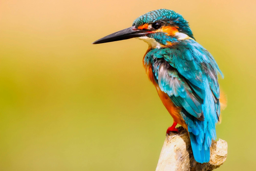

In [21]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

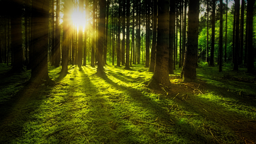

In [22]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [23]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [24]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

64

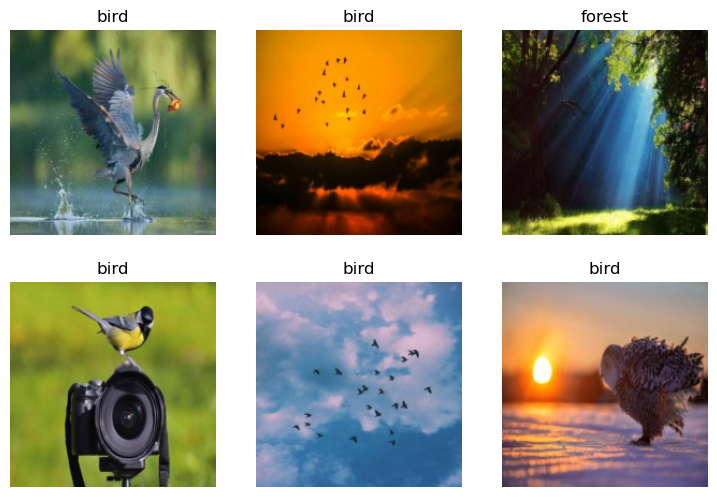

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rohit/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 63.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.565741,0.048174,0.011429,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.083901,0.032578,0.017143,00:05
1,0.059117,0.022637,0.011429,00:03
2,0.037041,0.015647,0.005714,00:03


## Step 3: Use our model (and build your own!)

In [27]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
